In [4]:
from pymilvus import MilvusClient

# K·∫øt n·ªëi t·ªõi Milvus server
milvus_client = MilvusClient(uri="http://localhost:19530")

# Ki·ªÉm tra k·∫øt n·ªëi b·∫±ng c√°ch li·ªát k√™ collection
try:
    collections = milvus_client.list_collections()
    print("K·∫øt n·ªëi th√†nh c√¥ng! Danh s√°ch collection:", collections)
except Exception as e:
    print("K·∫øt n·ªëi th·∫•t b·∫°i:", str(e))

K·∫øt n·ªëi th√†nh c√¥ng! Danh s√°ch collection: ['my_rag_collection', 'video_search', 'text_image_video_collection', 'image_collection', 'Movies']


In [5]:
# T·∫°o collection
collection_name = "image_collection"

# X√≥a collection n·∫øu ƒë√£ t·ªìn t·∫°i (n·∫øu mu·ªën b·∫Øt ƒë·∫ßu l·∫°i)
if milvus_client.has_collection(collection_name):
    milvus_client.drop_collection(collection_name)

# T·∫°o collection m·ªõi
milvus_client.create_collection(
    collection_name=collection_name,
    dimension=512,  # Chi·ªÅu d√†i vector t·ª´ CLIP (ViT-B/32)
    auto_id=True,   # T·ª± ƒë·ªông t·∫°o ID
    enable_dynamic_field=True,  # H·ªó tr·ª£ field ƒë·ªông (nh∆∞ filepath)
)

# Ki·ªÉm tra l·∫°i danh s√°ch collection
collections = milvus_client.list_collections()
print("Danh s√°ch collection:", collections)

Danh s√°ch collection: ['image_collection', 'Movies', 'my_rag_collection', 'video_search', 'text_image_video_collection']


In [5]:
# -------------------------
# 1. Import th∆∞ vi·ªán c·∫ßn thi·∫øt
# -------------------------
import clip                      # Th∆∞ vi·ªán CLIP t·ª´ OpenAI ƒë·ªÉ encode image & text th√†nh vector
from PIL import Image            # D√πng ƒë·ªÉ m·ªü & x·ª≠ l√Ω ·∫£nh

# -------------------------
# 2. T·∫£i m√¥ h√¨nh CLIP
# -------------------------
model_name = "ViT-B/32"          # Ch·ªçn ki·∫øn tr√∫c m√¥ h√¨nh CLIP (Vision Transformer B/32)
model, preprocess = clip.load(model_name)   # T·∫£i m√¥ h√¨nh v√† h√†m ti·ªÅn x·ª≠ l√Ω ·∫£nh
model.eval()                     # ƒê·∫∑t m√¥ h√¨nh v·ªÅ ch·∫ø ƒë·ªô "evaluation" (kh√¥ng train, ch·ªâ inference)

# ---------------------------------------
# 3. H√†m m√£ h√≥a ·∫£nh th√†nh vector
# ---------------------------------------
def encode_image(image_path):
    """
    Input:  image_path (ƒë∆∞·ªùng d·∫´n ·∫£nh, v√≠ d·ª•: 'cat.jpg')
    Output: vector 512 chi·ªÅu bi·ªÉu di·ªÖn n·ªôi dung ·∫£nh
    """
    image = preprocess(Image.open(image_path)).unsqueeze(0)   # (a) m·ªü ·∫£nh, (b) ti·ªÅn x·ª≠ l√Ω, (c) th√™m batch dimension
    image_features = model.encode_image(image)                # Cho ·∫£nh qua CLIP ‚Üí nh·∫≠n embedding vector
    image_features /= image_features.norm(dim=-1, keepdim=True)  # Chu·∫©n h√≥a vector v·ªÅ ƒë·ªô d√†i 1 (normalize)
    return image_features.squeeze().tolist()   # Tr·∫£ v·ªÅ d·∫°ng list Python (thay v√¨ tensor)

# ---------------------------------------
# 4. H√†m m√£ h√≥a text th√†nh vector
# ---------------------------------------
def encode_text(text):
    """
    Input:  text (chu·ªói vƒÉn b·∫£n, v√≠ d·ª•: 'a cute cat')
    Output: vector 512 chi·ªÅu bi·ªÉu di·ªÖn n·ªôi dung vƒÉn b·∫£n
    """
    text_tokens = clip.tokenize(text)          # Bi·∫øn text th√†nh token ƒë·ªÉ m√¥ h√¨nh CLIP hi·ªÉu
    text_features = model.encode_text(text_tokens)  # Cho text qua CLIP ‚Üí nh·∫≠n embedding vector
    text_features /= text_features.norm(dim=-1, keepdim=True)  # Chu·∫©n h√≥a vector v·ªÅ ƒë·ªô d√†i 1
    return text_features.squeeze().tolist()   # Tr·∫£ v·ªÅ d·∫°ng list Python


# Data Ingestion

In [7]:
import os
from glob import glob

image_dir = "./images_folder/train_small" # Th∆∞ m·ª•c ch·ª©a ·∫£nh (dataset)
raw_data = []  # Danh s√°ch l∆∞u vector + ƒë∆∞·ªùng d·∫´n ·∫£nh
batch_size = 10  # Gi·∫£m xu·ªëng 10 ·∫£nh/l·∫ßn
    
for image_path in glob(os.path.join(image_dir, "**/*.jpg")): # Duy·ªát t·∫•t c·∫£ ·∫£nh ƒëu√¥i .JPEG (bao g·ªìm sub-folder)
    image_embedding = encode_image(image_path) # M√£ h√≥a ·∫£nh th√†nh vector b·∫±ng CLIP
    image_dict = {"vector": image_embedding, "filepath": image_path}
    raw_data.append(image_dict)
    
    if len(raw_data) >= batch_size:
        insert_result = milvus_client.insert(collection_name="image_collection", data=raw_data) # T√™n collection trong Milvus
        print(f"ƒê√£ ch√®n {insert_result['insert_count']} ·∫£nh.")
        raw_data = []  # Reset danh s√°ch

# Ch√®n ph·∫ßn c√≤n l·∫°i
if raw_data:
    insert_result = milvus_client.insert(collection_name="image_collection", data=raw_data)
    print(f"ƒê√£ ch√®n {insert_result['insert_count']} ·∫£nh c√≤n l·∫°i.")

ƒê√£ ch√®n 10 ·∫£nh.
ƒê√£ ch√®n 10 ·∫£nh.
ƒê√£ ch√®n 10 ·∫£nh.
ƒê√£ ch√®n 10 ·∫£nh.
ƒê√£ ch√®n 10 ·∫£nh.
ƒê√£ ch√®n 10 ·∫£nh.
ƒê√£ ch√®n 10 ·∫£nh.
ƒê√£ ch√®n 10 ·∫£nh.
ƒê√£ ch√®n 10 ·∫£nh.
ƒê√£ ch√®n 10 ·∫£nh.
ƒê√£ ch√®n 10 ·∫£nh.
ƒê√£ ch√®n 10 ·∫£nh.
ƒê√£ ch√®n 1 ·∫£nh c√≤n l·∫°i.


In [11]:
from deep_translator import GoogleTranslator

# VƒÉn b·∫£n c·∫ßn d·ªãch
text_vi = "con tr√¢u"

# D·ªãch t·ª´ Ti·∫øng Vi·ªát sang Ti·∫øng Anh
result = GoogleTranslator(source='vi', target='en').translate(text_vi)

# print("Ti·∫øng Vi·ªát:", text_vi)
# print("English:", result)


query_text = result                     # C√¢u truy v·∫•n (v√≠ d·ª•: t√¨m ch√≥ Doberman)
query_embedding = encode_text(query_text)   # M√£ h√≥a text th√†nh vector b·∫±ng CLIP

search_results = milvus_client.search(
    collection_name="image_collection",    # T√™n collection ƒë√£ t·∫°o trong Milvus
    data=[query_embedding],             # Vector query (n√™n ƒë·ªÉ list, v√¨ c√≥ th·ªÉ search nhi·ªÅu query m·ªôt l√∫c)
    limit=10,                           # Tr·∫£ v·ªÅ top 10 k·∫øt qu·∫£ g·∫ßn nh·∫•t
    output_fields=["filepath"],         # Ngo√†i vector similarity, tr·∫£ th√™m th√¥ng tin ƒë∆∞·ªùng d·∫´n ·∫£nh
)


Query text: buffalo

Search results:


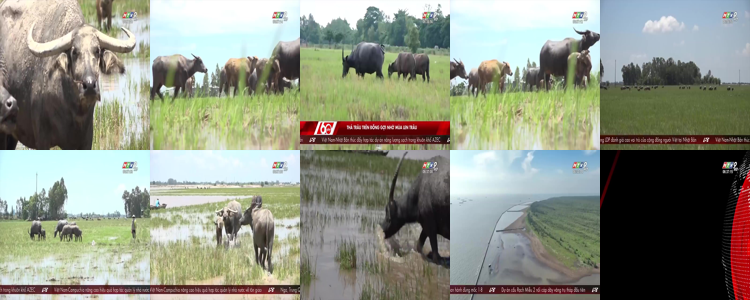

In [12]:
from IPython.display import display   # D√πng ƒë·ªÉ hi·ªÉn th·ªã ·∫£nh tr·ª±c ti·∫øp trong notebook/JupyterLab
from PIL import Image                 # Th∆∞ vi·ªán x·ª≠ l√Ω ·∫£nh (m·ªü, resize, gh√©p ·∫£nh)

# -----------------------------
# 1. T·∫°o m·ªôt "canvas" tr·ªëng ƒë·ªÉ d√°n k·∫øt qu·∫£ t√¨m ki·∫øm
# -----------------------------
width = 150 * 5     # 5 ·∫£nh m·ªói h√†ng, m·ªói ·∫£nh 150px
height = 150 * 2    # 2 h√†ng, m·ªói ·∫£nh 150px
concatenated_image = Image.new("RGB", (width, height))  
# -> T·∫°o 1 ·∫£nh tr·∫Øng (RGB) k√≠ch th∆∞·ªõc width √ó height, n∆°i s·∫Ω d√°n k·∫øt qu·∫£

# -----------------------------
# 2. Chu·∫©n b·ªã danh s√°ch ·∫£nh k·∫øt qu·∫£
# -----------------------------
result_images = []
for result in search_results:        # search_results ch·ª©a danh s√°ch c√°c k·∫øt qu·∫£ Milvus tr·∫£ v·ªÅ
    for hit in result:               # M·ªói result l√† 1 list c√°c "hit" (·∫£nh g·∫ßn nh·∫•t)
        filename = hit["entity"]["filepath"]   # L·∫•y ƒë∆∞·ªùng d·∫´n ·∫£nh t·ª´ metadata ƒë√£ l∆∞u trong Milvus
        img = Image.open(filename)             # M·ªü ·∫£nh g·ªëc t·ª´ filepath
        img = img.resize((150, 150))           # Resize ·∫£nh v·ªÅ 150√ó150 ƒë·ªÉ x·∫øp v√†o grid
        result_images.append(img)              # Th√™m ·∫£nh v√†o danh s√°ch k·∫øt qu·∫£

# -----------------------------
# 3. D√°n t·ª´ng ·∫£nh k·∫øt qu·∫£ v√†o canvas
# -----------------------------
for idx, img in enumerate(result_images):  
    x = idx % 5   # C·ªôt (mod 5 ƒë·ªÉ xu·ªëng h√†ng sau khi ƒë·ªß 5 ·∫£nh)
    y = idx // 5  # H√†ng
    concatenated_image.paste(img, (x * 150, y * 150))  
    # D√°n ·∫£nh v√†o v·ªã tr√≠ (x*150, y*150) tr√™n canvas

# -----------------------------
# 4. In query + hi·ªÉn th·ªã ·∫£nh k·∫øt qu·∫£
# -----------------------------
print(f"Query text: {query_text}")   # In c√¢u query ng∆∞·ªùi d√πng nh·∫≠p
print("\nSearch results:")           # In ti√™u ƒë·ªÅ
display(concatenated_image)          # Hi·ªÉn th·ªã ·∫£nh grid ch·ª©a c√°c k·∫øt qu·∫£ t√¨m ƒë∆∞·ª£c


## T·ªïng quan v·ªÅ m·ª•c ti√™u
Code n√†y x√¢y d·ª±ng m·ªôt h·ªá th·ªëng t√¨m ki·∫øm h√¨nh ·∫£nh d·ª±a tr√™n vƒÉn b·∫£n (text-to-image search) b·∫±ng c√°ch:

- d·ª•ng m√¥ h√¨nh CLIP ƒë·ªÉ t·∫°o embedding (bi·ªÉu di·ªÖn vector) cho c·∫£ vƒÉn b·∫£n v√† h√¨nh ·∫£nh.
- L∆∞u tr·ªØ c√°c embedding h√¨nh ·∫£nh trong Milvus (c∆° s·ªü d·ªØ li·ªáu vector).
- Th·ª±c hi·ªán t√¨m ki·∫øm t∆∞∆°ng t·ª± (similarity search) ƒë·ªÉ t√¨m h√¨nh ·∫£nh ph√π h·ª£p v·ªõi vƒÉn b·∫£n nh·∫≠p v√†o.

# phi√™n baÃân t√¥ÃÅi ∆∞u 
üöÄ T·ªëi ∆∞u ƒë√£ √°p d·ª•ng

- ViCLIP + PhoBERT cho query ti·∫øng Vi·ªát (# code t·ªëi ∆∞u).

- Milvus ƒë·ªÉ l∆∞u vector ·∫£nh.

- Query Expansion (m·ªü r·ªông nghƒ©a cho t·ª´ kh√≥a).

- Hybrid Retrieval = BM25 (t·ª´ kh√≥a) + Embedding (ng·ªØ nghƒ©a).

- Batch insert ƒë·ªÉ ti·∫øt ki·ªám RAM khi index nhi·ªÅu ·∫£nh.